In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
def parse_filename(file_name):
    parts = file_name.split('_')
    metadata = {
        "class_label": parts[3],  
        "gender": parts[4]
    }
    return metadata

In [5]:
def load_dataset(base_dir= '../train', lang='tamil'):
    dataset = []
    lang_dir = os.path.join(base_dir, lang)
    audio_dir = os.path.join(lang_dir, "audio")
    text_dir = os.path.join(lang_dir, "text")
    text_file = os.path.join(text_dir, [file for file in os.listdir(text_dir) if file.endswith(".xlsx")][0])
    text_df = pd.read_excel(text_file)
    for file in text_df['File Name']:
        if (file + ".wav") in os.listdir(audio_dir):
            metadata = parse_filename(file)
            audio_path = os.path.join(audio_dir, file + ".wav")
            transcript_row = text_df.loc[text_df["File Name"] == file]
            if not transcript_row.empty:
                transcript = transcript_row.iloc[0]["Transcript"]
                class_label_short = transcript_row.iloc[0]["Class Label Short"]
                dataset.append({
                    "audio_path": audio_path,
                    "transcript": transcript,
                    "class_label": class_label_short,
                    "gender": metadata["gender"]
                })
        else:
            transcript_row = text_df.loc[text_df["File Name"] == file]
            if not transcript_row.empty:
                transcript = transcript_row.iloc[0]["Transcript"]
                class_label_short = transcript_row.iloc[0]["Class Label Short"]
                dataset.append({
                    "audio_path": "Nil",
                    "transcript": transcript,
                    "class_label": class_label_short,
                    "gender": "Unknown"
                })
    return pd.DataFrame(dataset)

In [6]:
dataset_df = load_dataset()

In [7]:
data = dataset_df[dataset_df['audio_path'] != 'Nil']
data = dataset_df[dataset_df['audio_path'].apply(os.path.exists)]
data

,audio_path,transcript,class_label,gender
0,../train\tamil\audio\H_TA_003_C_M_016_005.wav,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...,C,M
1,../train\tamil\audio\H_TA_003_C_M_016_004.wav,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...,C,M
2,../train\tamil\audio\H_TA_003_C_M_016_003.wav,இந்த உருவத்தை வைத்து கிண்டல் கேலி பண்ணி சிரிக்...,C,M
3,../train\tamil\audio\H_TA_003_C_M_015_002.wav,புரிஞ்சுக்கணும் மேடையில் ஒரு நாகரிகம்னு ஒன்னு ...,C,M
4,../train\tamil\audio\H_TA_003_C_M_015_001.wav,என்னா மல மல அண்ணாமலை இது உலகத்தோட ஸ்டைலு உட்கா...,C,M
...,...,...,...,...
508,../train\tamil\audio\H_TA_002_C_F_007_001.wav,வெயிட்டா இருக்கான்னு பாடிசன் பண்ணாதீங்க யாரையும்,C,F
509,../train\tamil\audio\H_TA_002_C_F_006_001.wav,கேவலப்படுத்த அசிங்கப்படுது அவமானப்படுறது இதெல்...,C,F
510,../train\tamil\audio\H_TA_001_C_M_005_001.wav,ஏலே உன் மூஞ்சி மொகரையும் பாரு இல்லையே குற்றாலத...,C,M
511,../train\tamil\audio\H_TA_001_C_M_004_003.wav,மிகப்பெரிய தவறு விஜய் பனி இருக்கான் நிச்சயம் ...,C,M


In [8]:
data['audio_path'] = data['audio_path'].str.replace('\\', '/', regex=False)
data

C:\Users\VASANTHARAN\AppData\Local\Temp\ipykernel_271464\1349857448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['audio_path'] = data['audio_path'].str.replace('\\', '/', regex=False)


,audio_path,transcript,class_label,gender
0,../train/tamil/audio/H_TA_003_C_M_016_005.wav,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...,C,M
1,../train/tamil/audio/H_TA_003_C_M_016_004.wav,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...,C,M
2,../train/tamil/audio/H_TA_003_C_M_016_003.wav,இந்த உருவத்தை வைத்து கிண்டல் கேலி பண்ணி சிரிக்...,C,M
3,../train/tamil/audio/H_TA_003_C_M_015_002.wav,புரிஞ்சுக்கணும் மேடையில் ஒரு நாகரிகம்னு ஒன்னு ...,C,M
4,../train/tamil/audio/H_TA_003_C_M_015_001.wav,என்னா மல மல அண்ணாமலை இது உலகத்தோட ஸ்டைலு உட்கா...,C,M
...,...,...,...,...
508,../train/tamil/audio/H_TA_002_C_F_007_001.wav,வெயிட்டா இருக்கான்னு பாடிசன் பண்ணாதீங்க யாரையும்,C,F
509,../train/tamil/audio/H_TA_002_C_F_006_001.wav,கேவலப்படுத்த அசிங்கப்படுது அவமானப்படுறது இதெல்...,C,F
510,../train/tamil/audio/H_TA_001_C_M_005_001.wav,ஏலே உன் மூஞ்சி மொகரையும் பாரு இல்லையே குற்றாலத...,C,M
511,../train/tamil/audio/H_TA_001_C_M_004_003.wav,மிகப்பெரிய தவறு விஜய் பனி இருக்கான் நிச்சயம் ...,C,M


In [9]:
SAMPLE_RATE = 22050  
DURATION = 3  
MFCC_FEATURES = 40  
def extract_features(file_path, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [10]:
data['features'] = data['audio_path'].apply(lambda x: extract_features(x))
data = data.dropna(subset=['features'])
label_encoder = LabelEncoder()
data['class_label_encoded'] = label_encoder.fit_transform(data['class_label'])

C:\Users\VASANTHARAN\AppData\Local\Temp\ipykernel_271464\3469351543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['features'] = data['audio_path'].apply(lambda x: extract_features(x))


In [11]:
X = np.array(data['features'].tolist())
y = tf.keras.utils.to_categorical(data['class_label_encoded'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train = np.expand_dims(X_train, axis=-1) 
X_test = np.expand_dims(X_test, axis=-1)

In [12]:
X_train

array([[[[-202.50606  ]],

        [[ 140.79485  ]],

        [[ -26.396807 ]],

        ...,

        [[   2.4485438]],

        [[  -2.365914 ]],

        [[   1.7438297]]],


       [[[-256.1126   ]],

        [[ 107.49445  ]],

        [[ -17.844328 ]],

        ...,

        [[  -5.432516 ]],

        [[  -4.518503 ]],

        [[  -3.3120265]]],


       [[[-269.70322  ]],

        [[ 103.58383  ]],

        [[ -11.993969 ]],

        ...,

        [[  -2.8730633]],

        [[  -4.240417 ]],

        [[  -1.6995257]]],


       ...,


       [[[-173.95955  ]],

        [[ 126.90879  ]],

        [[   2.4727957]],

        ...,

        [[   2.5989537]],

        [[  -1.7722164]],

        [[  -0.5425162]]],


       [[[-249.38232  ]],

        [[ 182.89258  ]],

        [[ -23.895903 ]],

        ...,

        [[  -4.573374 ]],

        [[  -3.2166698]],

        [[  -2.3717206]]],


       [[[ -82.94032  ]],

        [[  84.033806 ]],

        [[  11.777252 ]],

        ...,

 

In [18]:
model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,645 (283.77 KB)

 Trainable params: 72,645 (283.77 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2)

Epoch 1/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3051 - loss: 7.8062 - val_accuracy: 0.5244 - val_loss: 3.2696
Epoch 2/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3731 - loss: 3.9550 - val_accuracy: 0.5244 - val_loss: 1.8010
Epoch 3/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4599 - loss: 2.6197 - val_accuracy: 0.5366 - val_loss: 1.3979
Epoch 4/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4780 - loss: 1.8712 - val_accuracy: 0.5122 - val_loss: 1.3807
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5160 - loss: 1.6067 - val_accuracy: 0.5244 - val_loss: 1.3386
Epoch 6/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4879 - loss: 1.6699 - val_accuracy: 0.5244 - val_loss: 1.3377
Epoch 7/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4904 - loss: 1.4116 - val_accuracy: 0.5244 - val_loss: 1.3406
Epoch 8/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5419 - loss: 1.3542 - val_accuracy: 0.

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6122 - loss: 1.6394
Test Accuracy: 63.73%


In [21]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
              precision    recall  f1-score   support

           C       0.57      0.25      0.35        16
           G       0.55      0.46      0.50        13
           N       0.67      0.89      0.76        53
           P       0.50      0.12      0.20         8
           R       0.58      0.58      0.58        12

    accuracy                           0.64       102
   macro avg       0.57      0.46      0.48       102
weighted avg       0.62      0.64      0.60       102



In [22]:
model.save("../models/tamil_audio_classification_model_without_preprocessing.h5")

In [105]:
np.save("../label encoder/label_encoder_classes.npy", label_encoder.classes_)

With TTSAudioNormalizer and DynamicAudioNormalizer

In [23]:
def tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=0.0):
    target_amplitude = 10 ** (target_peak / 20)
    current_peak = np.max(np.abs(audio))
    if current_peak > 0:
        normalization_factor = target_amplitude / current_peak
    else:
        normalization_factor = 1.0
    normalized_audio = audio * normalization_factor
    gain_amplitude = 10 ** (gain_dB / 20)
    normalized_audio = normalized_audio * gain_amplitude
    return normalized_audio
def dynamic_audio_normalizer(audio, sr):
    peak = np.max(np.abs(audio))
    if peak > 0:
        return audio / peak
    return audio

Original Audio:


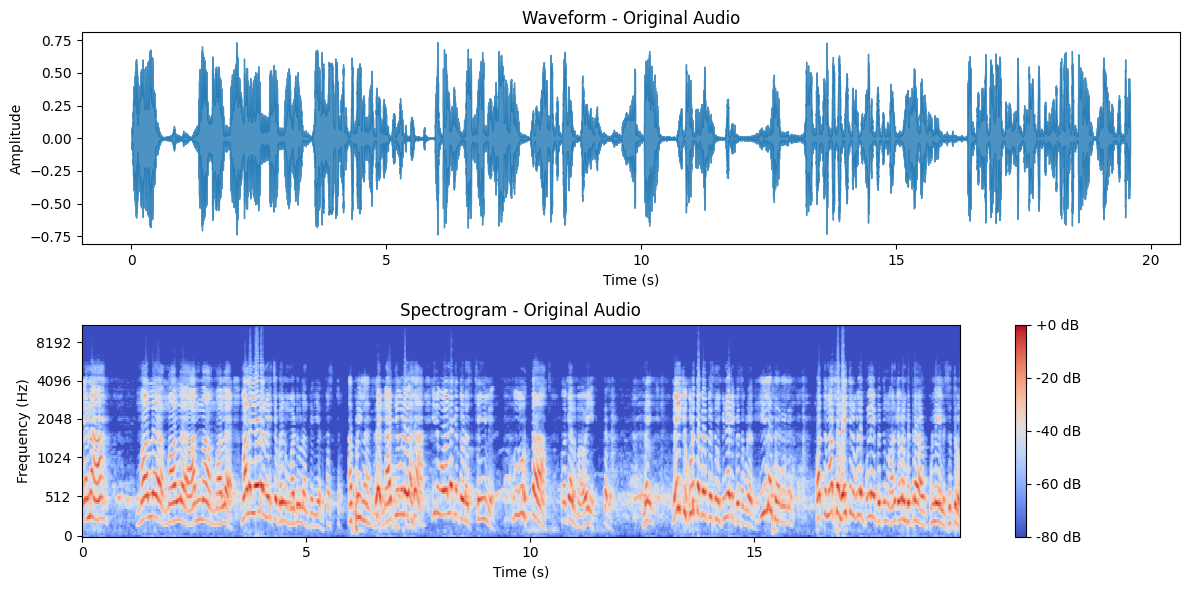

Normalized Audio:


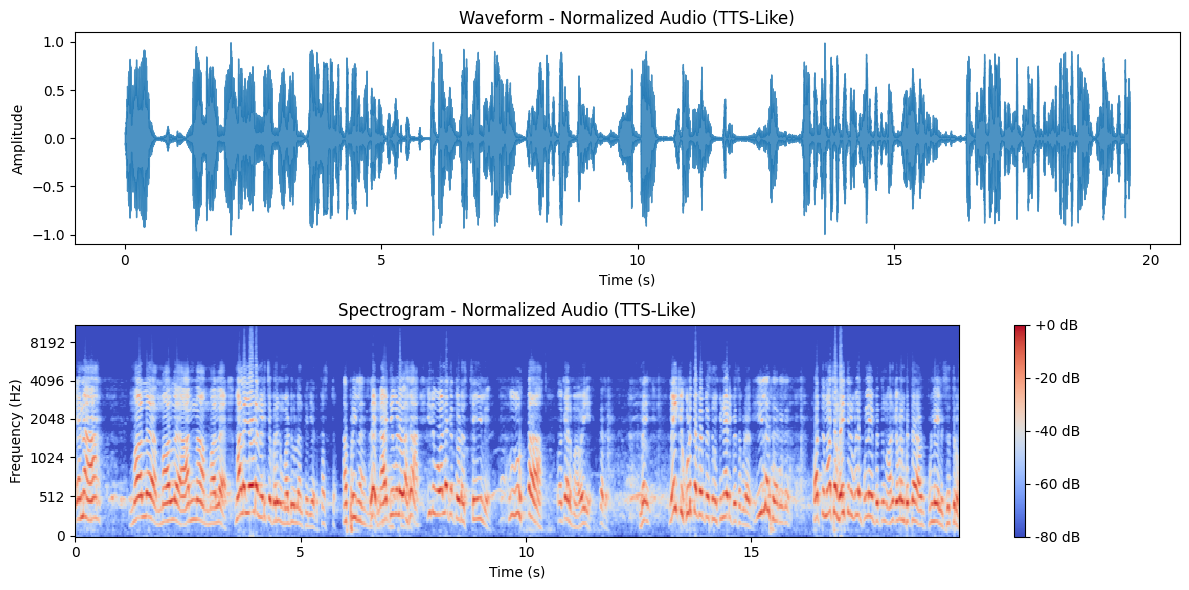

In [24]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr, alpha=0.8)
    plt.title(f"Waveform - {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.subplot(2, 1, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram - {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
file_path = "../train/tamil/audio/H_TA_003_C_M_015_001.wav" 
SAMPLE_RATE = 22050
audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
print("Original Audio:")
plot_spectrogram(audio, sr, "Original Audio")
display(Audio(audio, rate=sr))
normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
print("Normalized Audio:")
plot_spectrogram(normalized_audio, sr, "Normalized Audio (TTS-Like)")
display(Audio(normalized_audio, rate=sr))

In [25]:
def extract_features(file_path, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)  
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [26]:
data['processed features'] = data['audio_path'].apply(lambda x: extract_features(x))

In [27]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/tamil/audio/H_TA_003_C_M_016_005.wav,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...,C,M,"[-113.59984, 179.13167, -38.382843, 16.501377,...",0,"[-109.89169, 179.13167, -38.382843, 16.501375,..."
1,../train/tamil/audio/H_TA_003_C_M_016_004.wav,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...,C,M,"[-119.25441, 192.32378, -55.749092, 3.0560663,...",0,"[-110.580475, 192.32379, -55.749092, 3.056068,..."
2,../train/tamil/audio/H_TA_003_C_M_016_003.wav,இந்த உருவத்தை வைத்து கிண்டல் கேலி பண்ணி சிரிக்...,C,M,"[-108.43434, 172.43083, -43.537273, 24.166769,...",0,"[-107.500244, 172.43083, -43.537273, 24.16677,..."
3,../train/tamil/audio/H_TA_003_C_M_015_002.wav,புரிஞ்சுக்கணும் மேடையில் ஒரு நாகரிகம்னு ஒன்னு ...,C,M,"[-256.62964, 155.96031, -19.707636, 21.540794,...",0,"[-226.41257, 155.96031, -19.70764, 21.540798, ..."
4,../train/tamil/audio/H_TA_003_C_M_015_001.wav,என்னா மல மல அண்ணாமலை இது உலகத்தோட ஸ்டைலு உட்கா...,C,M,"[-267.8949, 148.52771, -32.60208, 20.261002, -...",0,"[-237.68896, 148.52773, -32.602085, 20.261002,..."
...,...,...,...,...,...,...,...
508,../train/tamil/audio/H_TA_002_C_F_007_001.wav,வெயிட்டா இருக்கான்னு பாடிசன் பண்ணாதீங்க யாரையும்,C,F,"[-177.97418, 123.59612, -32.017056, 4.621558, ...",0,"[-178.72792, 123.59614, -32.01706, 4.6215596, ..."
509,../train/tamil/audio/H_TA_002_C_F_006_001.wav,கேவலப்படுத்த அசிங்கப்படுது அவமானப்படுறது இதெல்...,C,F,"[-353.46698, 167.04799, -9.243407, 25.89382, -...",0,"[-207.79828, 167.04797, -9.243405, 25.893818, ..."
510,../train/tamil/audio/H_TA_001_C_M_005_001.wav,ஏலே உன் மூஞ்சி மொகரையும் பாரு இல்லையே குற்றாலத...,C,M,"[-202.50606, 140.79485, -26.396807, 8.801536, ...",0,"[-161.28586, 140.79485, -26.396807, 8.801537, ..."
511,../train/tamil/audio/H_TA_001_C_M_004_003.wav,மிகப்பெரிய தவறு விஜய் பனி இருக்கான் நிச்சயம் ...,C,M,"[-101.116844, 119.430374, -44.17786, -0.368103...",0,"[-85.78236, 119.430374, -44.17786, -0.36810398..."


In [28]:
data = data.dropna(subset=['processed features'])

In [29]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/tamil/audio/H_TA_003_C_M_016_005.wav,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...,C,M,"[-113.59984, 179.13167, -38.382843, 16.501377,...",0,"[-109.89169, 179.13167, -38.382843, 16.501375,..."
1,../train/tamil/audio/H_TA_003_C_M_016_004.wav,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...,C,M,"[-119.25441, 192.32378, -55.749092, 3.0560663,...",0,"[-110.580475, 192.32379, -55.749092, 3.056068,..."
2,../train/tamil/audio/H_TA_003_C_M_016_003.wav,இந்த உருவத்தை வைத்து கிண்டல் கேலி பண்ணி சிரிக்...,C,M,"[-108.43434, 172.43083, -43.537273, 24.166769,...",0,"[-107.500244, 172.43083, -43.537273, 24.16677,..."
3,../train/tamil/audio/H_TA_003_C_M_015_002.wav,புரிஞ்சுக்கணும் மேடையில் ஒரு நாகரிகம்னு ஒன்னு ...,C,M,"[-256.62964, 155.96031, -19.707636, 21.540794,...",0,"[-226.41257, 155.96031, -19.70764, 21.540798, ..."
4,../train/tamil/audio/H_TA_003_C_M_015_001.wav,என்னா மல மல அண்ணாமலை இது உலகத்தோட ஸ்டைலு உட்கா...,C,M,"[-267.8949, 148.52771, -32.60208, 20.261002, -...",0,"[-237.68896, 148.52773, -32.602085, 20.261002,..."
...,...,...,...,...,...,...,...
508,../train/tamil/audio/H_TA_002_C_F_007_001.wav,வெயிட்டா இருக்கான்னு பாடிசன் பண்ணாதீங்க யாரையும்,C,F,"[-177.97418, 123.59612, -32.017056, 4.621558, ...",0,"[-178.72792, 123.59614, -32.01706, 4.6215596, ..."
509,../train/tamil/audio/H_TA_002_C_F_006_001.wav,கேவலப்படுத்த அசிங்கப்படுது அவமானப்படுறது இதெல்...,C,F,"[-353.46698, 167.04799, -9.243407, 25.89382, -...",0,"[-207.79828, 167.04797, -9.243405, 25.893818, ..."
510,../train/tamil/audio/H_TA_001_C_M_005_001.wav,ஏலே உன் மூஞ்சி மொகரையும் பாரு இல்லையே குற்றாலத...,C,M,"[-202.50606, 140.79485, -26.396807, 8.801536, ...",0,"[-161.28586, 140.79485, -26.396807, 8.801537, ..."
511,../train/tamil/audio/H_TA_001_C_M_004_003.wav,மிகப்பெரிய தவறு விஜய் பனி இருக்கான் நிச்சயம் ...,C,M,"[-101.116844, 119.430374, -44.17786, -0.368103...",0,"[-85.78236, 119.430374, -44.17786, -0.36810398..."


In [30]:
X = np.array(data['processed features'].tolist())
label_encoder = LabelEncoder()
data['class_label_encoded'] = label_encoder.fit_transform(data['class_label'])
y = tf.keras.utils.to_categorical(data['class_label_encoded'])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis, np.newaxis]  
X_test = X_test[..., np.newaxis, np.newaxis]

In [32]:
norm_model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])

norm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
norm_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,885 (511.27 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = norm_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

Epoch 1/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3514 - loss: 4.3150 - val_accuracy: 0.5645 - val_loss: 1.3542
Epoch 2/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3949 - loss: 1.8668 - val_accuracy: 0.5323 - val_loss: 1.2921
Epoch 3/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4489 - loss: 1.5832 - val_accuracy: 0.5806 - val_loss: 1.3514
Epoch 4/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5359 - loss: 1.3600 - val_accuracy: 0.5968 - val_loss: 1.3360
Epoch 5/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5442 - loss: 1.4240 - val_accuracy: 0.6129 - val_loss: 1.3515
Epoch 6/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5140 - loss: 1.3151 - val_accuracy: 0.5968 - val_loss: 1.2877
Epoch 7/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5995 - loss: 1.2248 - val_accuracy: 0.5968 - val_loss: 1.2568
Epoch 8/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5827 - loss: 1.1750 - val_accuracy: 0.6129 - v

In [34]:
test_loss, test_accuracy = norm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5605 - loss: 1.1253
Test Accuracy: 57.84%


In [35]:
y_pred = norm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
              precision    recall  f1-score   support

           C       0.50      0.12      0.20        16
           G       0.45      0.38      0.42        13
           N       0.62      0.85      0.72        53
           P       0.33      0.25      0.29         8
           R       0.56      0.42      0.48        12

    accuracy                           0.58       102
   macro avg       0.49      0.41      0.42       102
weighted avg       0.55      0.58      0.54       102



In [36]:
norm_model.save("../models/tamil_audio_classification_model_with_normalizers.h5")

Data Augmentation

In [37]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/tamil/audio/H_TA_003_C_M_016_005.wav,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...,C,M,"[-113.59984, 179.13167, -38.382843, 16.501377,...",0,"[-109.89169, 179.13167, -38.382843, 16.501375,..."
1,../train/tamil/audio/H_TA_003_C_M_016_004.wav,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...,C,M,"[-119.25441, 192.32378, -55.749092, 3.0560663,...",0,"[-110.580475, 192.32379, -55.749092, 3.056068,..."
2,../train/tamil/audio/H_TA_003_C_M_016_003.wav,இந்த உருவத்தை வைத்து கிண்டல் கேலி பண்ணி சிரிக்...,C,M,"[-108.43434, 172.43083, -43.537273, 24.166769,...",0,"[-107.500244, 172.43083, -43.537273, 24.16677,..."
3,../train/tamil/audio/H_TA_003_C_M_015_002.wav,புரிஞ்சுக்கணும் மேடையில் ஒரு நாகரிகம்னு ஒன்னு ...,C,M,"[-256.62964, 155.96031, -19.707636, 21.540794,...",0,"[-226.41257, 155.96031, -19.70764, 21.540798, ..."
4,../train/tamil/audio/H_TA_003_C_M_015_001.wav,என்னா மல மல அண்ணாமலை இது உலகத்தோட ஸ்டைலு உட்கா...,C,M,"[-267.8949, 148.52771, -32.60208, 20.261002, -...",0,"[-237.68896, 148.52773, -32.602085, 20.261002,..."
...,...,...,...,...,...,...,...
508,../train/tamil/audio/H_TA_002_C_F_007_001.wav,வெயிட்டா இருக்கான்னு பாடிசன் பண்ணாதீங்க யாரையும்,C,F,"[-177.97418, 123.59612, -32.017056, 4.621558, ...",0,"[-178.72792, 123.59614, -32.01706, 4.6215596, ..."
509,../train/tamil/audio/H_TA_002_C_F_006_001.wav,கேவலப்படுத்த அசிங்கப்படுது அவமானப்படுறது இதெல்...,C,F,"[-353.46698, 167.04799, -9.243407, 25.89382, -...",0,"[-207.79828, 167.04797, -9.243405, 25.893818, ..."
510,../train/tamil/audio/H_TA_001_C_M_005_001.wav,ஏலே உன் மூஞ்சி மொகரையும் பாரு இல்லையே குற்றாலத...,C,M,"[-202.50606, 140.79485, -26.396807, 8.801536, ...",0,"[-161.28586, 140.79485, -26.396807, 8.801537, ..."
511,../train/tamil/audio/H_TA_001_C_M_004_003.wav,மிகப்பெரிய தவறு விஜய் பனி இருக்கான் நிச்சயம் ...,C,M,"[-101.116844, 119.430374, -44.17786, -0.368103...",0,"[-85.78236, 119.430374, -44.17786, -0.36810398..."


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
def augment_audio(audio, sr):
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise
    audio_stretch = librosa.effects.time_stretch(audio, rate=0.8)
    audio_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=4)
    return [audio, audio_noise, audio_stretch, audio_shift]
augmented_data = []
def extract_features(audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None
for index, row in data.iterrows():
    audio, sr = librosa.load(row['audio_path'], sr=SAMPLE_RATE)
    augmented_audios = augment_audio(audio, sr)
    for aug_audio in augmented_audios:
        features = extract_features(aug_audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE)
        if features is not None:
            augmented_data.append({
                'features': features,
                'class_label': row['class_label']
            })

augmented_df = pd.DataFrame(augmented_data)
augmented_df

,features,class_label
0,"[-113.9303, 178.97498, -43.82271, 17.039688, 6...",C
1,"[-88.11886778375695, 145.72224498743216, -20.2...",C
2,"[-146.07407, 180.4039, -45.91897, 16.282007, 6...",C
3,"[-129.6522, 157.67537, -55.07253, 24.414268, -...",C
4,"[-116.57965, 184.62589, -51.11227, 11.285077, ...",C
...,...,...
2031,"[-182.94447, 119.96929, -61.970222, -1.4315125...",C
2032,"[-217.19109, 158.96347, -22.33011, -0.6860686,...",C
2033,"[-152.44133844758218, 106.79477159314179, -1.3...",C
2034,"[-250.83058, 162.01364, -25.540802, -2.136042,...",C


In [39]:
label_encoder = LabelEncoder()
augmented_df['class_label_encoded'] = label_encoder.fit_transform(augmented_df['class_label'])

In [40]:
augmented_df

,features,class_label,class_label_encoded
0,"[-113.9303, 178.97498, -43.82271, 17.039688, 6...",C,0
1,"[-88.11886778375695, 145.72224498743216, -20.2...",C,0
2,"[-146.07407, 180.4039, -45.91897, 16.282007, 6...",C,0
3,"[-129.6522, 157.67537, -55.07253, 24.414268, -...",C,0
4,"[-116.57965, 184.62589, -51.11227, 11.285077, ...",C,0
...,...,...,...
2031,"[-182.94447, 119.96929, -61.970222, -1.4315125...",C,0
2032,"[-217.19109, 158.96347, -22.33011, -0.6860686,...",C,0
2033,"[-152.44133844758218, 106.79477159314179, -1.3...",C,0
2034,"[-250.83058, 162.01364, -25.540802, -2.136042,...",C,0


In [41]:
X_augmented = np.array(augmented_df['features'].tolist())
y_augmented = tf.keras.utils.to_categorical(augmented_df['class_label_encoded'])
X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis, np.newaxis]
X_test = X_test[..., np.newaxis, np.newaxis]

In [42]:
aug_model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aug_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,885 (511.27 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = aug_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4193 - loss: 4.8871 - val_accuracy: 0.5637 - val_loss: 3.4708 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5479 - loss: 3.3023 - val_accuracy: 0.5882 - val_loss: 2.7194 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5962 - loss: 2.6484 - val_accuracy: 0.5613 - val_loss: 2.2453 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5907 - loss: 2.2077 - val_accuracy: 0.5980 - val_loss: 1.9964 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6027 - loss: 1.9179 - val_accuracy: 0.6078 - val_loss: 1.7643 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6018 - loss: 1.7047 - val_accuracy: 0.5980 - val_loss: 1.6342 - learning_rate: 0.0010
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5803 - loss: 1.5974 - v

In [44]:
test_loss, test_accuracy = aug_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8379 - loss: 0.6705
Test Accuracy: 84.87%


In [45]:
y_pred = aug_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           C       0.93      0.59      0.72        64
           G       0.67      0.73      0.70        74
           N       0.88      0.93      0.90       276
           P       0.93      0.79      0.86        34
           R       0.85      0.92      0.88        61

    accuracy                           0.85       509
   macro avg       0.85      0.79      0.81       509
weighted avg       0.85      0.85      0.85       509



In [46]:
aug_model.save("../models/tamil_augmentation_model.h5")

In [47]:
from tensorflow.keras.layers import BatchNormalization
imp_aug_model = Sequential([
    Conv2D(64, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(256, (3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
imp_aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
imp_aug_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 38, 1, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 19, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 17, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 1, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 3, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,653 (2.00 MB)

 Trainable params: 521,733 (1.99 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('../models/tamil_best_audio_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
history = imp_aug_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.3511 - loss: 2.2010 - val_accuracy: 0.4632 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4865 - loss: 1.5689 - val_accuracy: 0.6201 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5523 - loss: 1.2997 - val_accuracy: 0.6152 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5909 - loss: 1.1789 - val_accuracy: 0.6618 - val_loss: 0.9080 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6151 - loss: 1.0428 - val_accuracy: 0.6838 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6532 - loss: 0.9952 - val_accuracy: 0.6912 - val_loss: 0.8235 - learning_rate: 0.0010
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6555 - loss: 0.9367 - 

In [49]:
best_model = tf.keras.models.load_model('../models/tamil_best_audio_model.keras')
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8683 - loss: 0.4706 
Best Model Test Accuracy: 87.62%


In [50]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           C       0.90      0.70      0.79        64
           G       0.79      0.70      0.74        74
           N       0.88      0.96      0.92       276
           P       0.90      0.82      0.86        34
           R       0.90      0.93      0.92        61

    accuracy                           0.88       509
   macro avg       0.88      0.82      0.85       509
weighted avg       0.88      0.88      0.87       509



In [55]:
X_test.shape

(509, 40, 1, 1)

In [56]:
file_path = "../train/tamil/audio/H_TA_003_C_M_016_005.wav"
audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
def extract_features(audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

features = extract_features(audio)
features.shape

(40,)

In [57]:
reshaped_features = features.reshape((MFCC_FEATURES, 1, 1))
reshaped_features.shape

(40, 1, 1)

In [59]:
reshaped_features = features.reshape((1, MFCC_FEATURES, 1, 1))
predicted_class = np.argmax(best_model.predict(reshaped_features), axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: C
